In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn import datasets
from sklearn.model_selection import train_test_split
from src.perceptron import SimplePerceptron

## Construir Datos

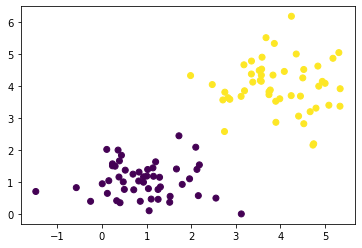

In [132]:
X, y = datasets.make_blobs(
    n_samples=100, n_features=2, centers=[(1,1), (4,4)], cluster_std=0.75
)
y = [1 if i == 1 else -1 for i in y]
plt.scatter(X[:, 0], X[:, 1], c=y)


plt.show()

### Elimino elementos fuera de rango

Removed 13 out of bounds elements


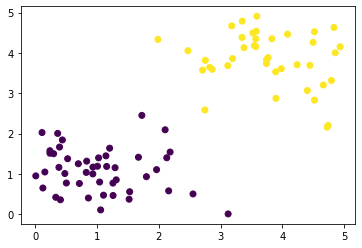

In [133]:
offenders = np.argwhere(np.any((X < 0) | (X > 5), axis=1))
X_c = np.delete(X, offenders, 0)
y_c = np.delete(y, offenders, 0)
print(f"Removed {len(offenders)} out of bounds elements")
plt.scatter(X_c[:, 0], X_c[:, 1], c=y_c)
plt.show()

## Clasificando con el perceptron simple

In [233]:
def line(p1, p2):
    m = (p1[1] - p2[1])/(p1[0] - p2[0])
    b = p1[1] - p1[0]*m
    return (m, b)

def perpendicular_line(line, point):
    m, b = line
    return (-1/m, point[1] - point[0]*(-1/m))

def line_intersection(line1, line2):
    m1, b1 = line1
    m2, b2 = line2
    
    # same gradient different y-intercept never cross
    if m1 == m2 and b1 != b2:
        return None
    
    x = (b1 - b2) / (m2 - m1)
    y = m1*x + b1
    return np.array([x, y])

def distance(point,coef):
    return abs((coef[0]*point[0])-point[1]+coef[1])/np.sqrt((coef[0]*coef[0])+1)

def translate_line(line, point):
    m, b = line
    return (m, point[1] - m*point[0])

def separator_line(l, point):
    m, b = l
    aux_line = perpendicular_line(l, point)
    intersect = line_intersection(l, aux_line)
    p = 0.5*(intersect + point)
    return p, (m, p[1]-m*p[0])

# test distance works
expected_d = np.sqrt(2)/2
actual_d = distance_to_line((0, 0), ((0, 1), (1, 0)))
actual_d = distance((0, 0), (-1, 1))

print(f"actual distance: {actual_d}")
print(expected_d - actual_d < 1e-15)

actual distance: 0.7071067811865475
True


In [134]:
p = SimplePerceptron(X_c, y_c, learning_rate=0.01, limit=10000)

In [271]:
def get_best_separator(x, y, current_separator, n=2):
    # order points by distance to perceptron hyperplane
    m, b = current_separator
    ordered_zip = sorted(zip(x, y), key = lambda t: distance(t[0], (m, b)))
    i = [list(t) for t in zip(*ordered_zip)]
    xi = np.array(i[0])
    yi = np.array(i[1])
   
    n_reds = x[np.where(y == -1)[0][:n]]
    n_blues = x[np.where(y == 1)[0][:n]]
    
    end_points = None
    end_point = None
    end_m1 = None
    end_m2 = None
    end_s_point = None
    end_separator = current_separator
    
    def min_distance(X, sep):
        return min([distance(x_i, sep) for x_i in X])
    
    all_groups = [n_reds, n_blues]
    for i, class_points in enumerate(all_groups):
        for points in combinations(all_groups[i], 2):
            other = 1 if i == 0 else 0
            for point in all_groups[other]:
                margin1 = line_from_points(points[0], points[1])
                margin2 = translate_line(margin1, point)
                s_point, separator = separator_line(margin1, point)
                curr_min_distance = min_distance(xi, separator)
                if curr_min_distance > min_distance(xi, end_separator):
                    end_points = points
                    end_point = point
                    end_m1 = margin1
                    end_m2 = margin2
                    end_s_point = s_point
                    end_separator = separator
            
            
    return end_points, end_point, end_m1, end_m2, end_s_point, end_separator

In [349]:
def visualize(x, y, w, title, clf=None, optimum=False, n=2):
    weights = w
    _, ax = plt.subplots(figsize=(8,8))
    m = -weights[0]/weights[1]
    b = -weights[2]/weights[1]
    
    
    # order points by distance to perceptron hyperplane
    ordered_zip = sorted(zip(x, y), key = lambda t: distance(t[0], (m, b)))
    i = [list(t) for t in zip(*ordered_zip)]
    xi = np.array(i[0])
    yi = np.array(i[1])
    colors = ['red' if i == -1 else 'blue' for i in yi]
    edgecolors = colors.copy()
    if optimum:
        alpha = np.array([0.5]*len(y))
        n_red_idx = np.where(yi == -1)[0][:n]
        n_blue_idx = np.where(yi == 1)[0][:n]
        alpha[n_red_idx] = alpha[n_blue_idx] = 1
       
        result = get_best_separator(xi, yi, (m, b))
        r_points, b_point, m_r, m_b , s_point, separator = result
        f_indexes = []
        for p in r_points:
            index = np.where(xi == p)[0][0]
            f_indexes.append(index)
            edgecolors[index] = 'black'
            alpha[index] = 1
        index = np.where(xi == b_point)[0][0]
        f_indexes.append(index)
        edgecolors[index] = 'black'
        alpha[index] = 1
       
        ax.axline(b_point, slope=m_b[0], c='purple', alpha=0.4)
        ax.axline(r_points[0], slope=m_r[0], c='purple', alpha=0.4)
        ax.axline(s_point, slope=separator[0], c='black', label='Optimal')
    else:
        alpha = 1 
    if clf is not None:
        svm_w = clf.coef_[0]
        svm_m = (-svm_w[0]/svm_w[1])
        svm_b = (clf.intercept_[0]/svm_w[1])
        
        svm_y = xi * svm_m - svm_b
        ax.plot(xi, svm_y, color='green')
    
               
    ax.scatter(xi[:, 0], xi[:, 1], marker="o", c=colors, alpha=alpha, edgecolors=edgecolors)
    
    ax.set_title(title)

    x0_1 = np.amin(x[:, 0])
    x0_2 = np.amax(x[:, 0])
    d=0
    ax.set_xlim(0-d, 5+d)
    ax.set_ylim(0-d, 5+d)
    if weights[2] != 0:
        # w_y*y + w_x*x + w0 = 0
        # => y = (-w_x*x - w0) / w_y
        x1_1 = (-weights[0] * x0_1 - weights[2]) / weights[1]
        ax.axline((x0_1, x1_1), slope=m, color='orange', label='Simple Perceptron')
    ax.legend()    
    plt.show()
print(f"Pesos que minimizan el error: {list(p.min_weights)}")

Pesos que minimizan el error: [0.06542619230281252, 0.02795445414011851, -0.23999999999999996]


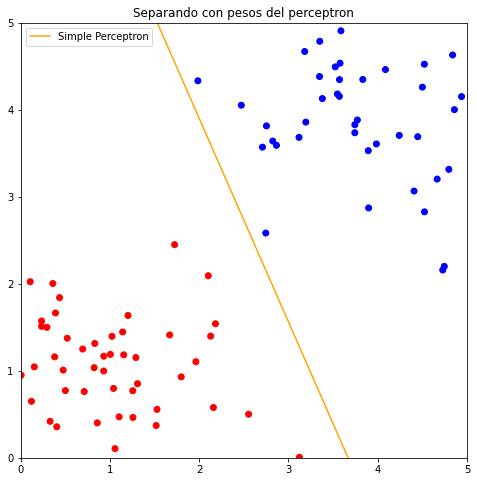

In [246]:
visualize(X_c, y_c, p.min_weights, 'Separando con pesos del perceptron', optimum=False)


La recta de separación **no** es óptima, ya que da resultados distintos al entrenar al perceptron con los mismos datos (por el aspecto aleatorio del entrenamiento del perceptron). Dependiendo la corrida puede quedar mas cerca de uno de los grupos, o tratar de separar a los elementos con una linea tendiendo a vertical. Teniendo en cuenta como se generan los datos, tendria sentido que el separador sea una linea similar a $y=-x+5$

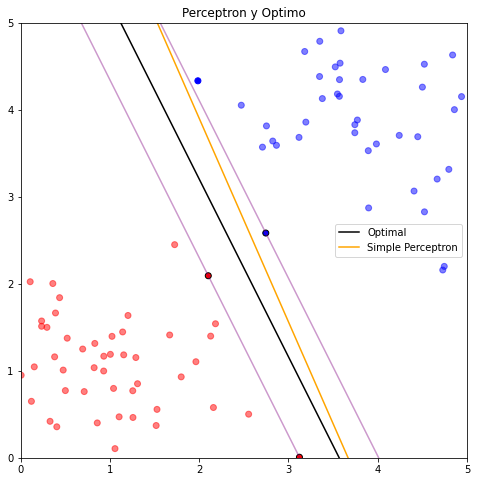

In [278]:
visualize(X_c, y_c, p.min_weights, 'Perceptron y Optimo', optimum=True, n=2)


## Construir datos con errores

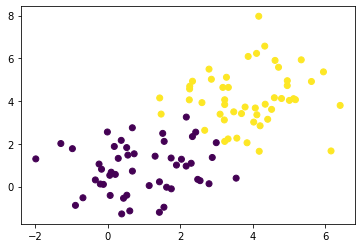

In [300]:
Xe, ye = datasets.make_blobs(
    n_samples=100, n_features=2, centers=[(1,1), (4,4)], cluster_std=1.2
)
ye = [1 if i == 1 else -1 for i in ye]
plt.scatter(Xe[:, 0], Xe[:, 1], c=ye)


plt.show()

Removed 37 out of bounds elements


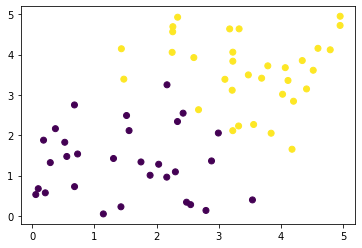

In [301]:
offenderse = np.argwhere(np.any((Xe < 0) | (Xe > 5), axis=1))
X_ce = np.delete(Xe, offenderse, 0)
y_ce = np.delete(ye, offenderse, 0)
print(f"Removed {len(offenderse)} out of bounds elements")
plt.scatter(X_ce[:, 0], X_ce[:, 1], c=y_ce)
plt.show()

In [302]:
pe = SimplePerceptron(X_ce, y_ce, learning_rate=0.01, limit=10000)

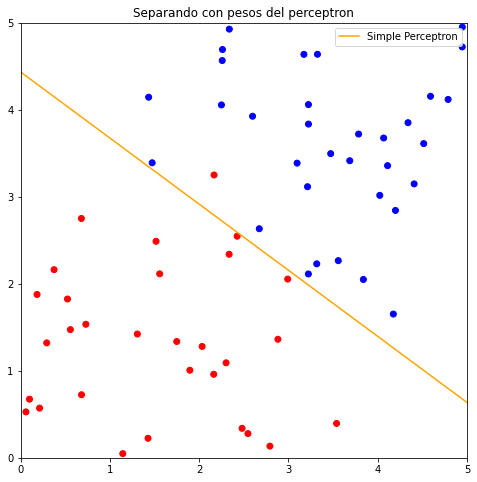

In [303]:
visualize(X_ce, y_ce, pe.min_weights, 'Separando con pesos del perceptron', optimum=False)

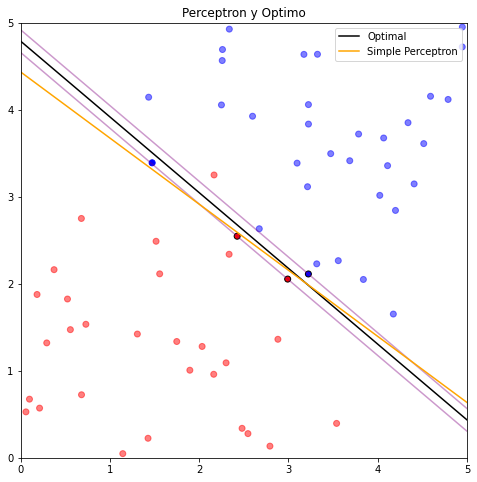

In [304]:
visualize(X_ce, y_ce, pe.min_weights, 'Perceptron y Optimo', optimum=True, n=2)


## Usando SVM para clasificar los datos

### TP3-1

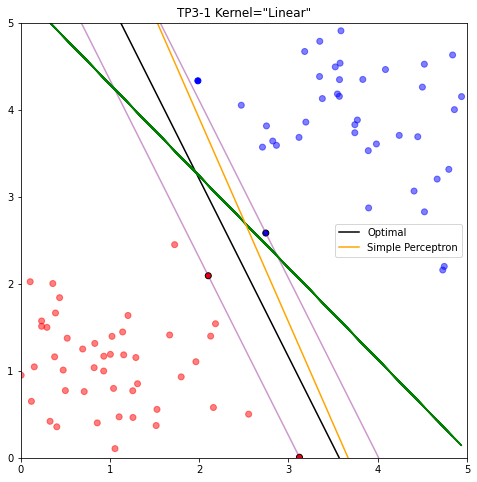

In [353]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_c, y_c)

#visualize_clf(X_c, y_c, clf, title="No importa")
visualize(X_c, y_c, p.min_weights, 'TP3-1 Kernel="Linear"', clf=clf, optimum=True)


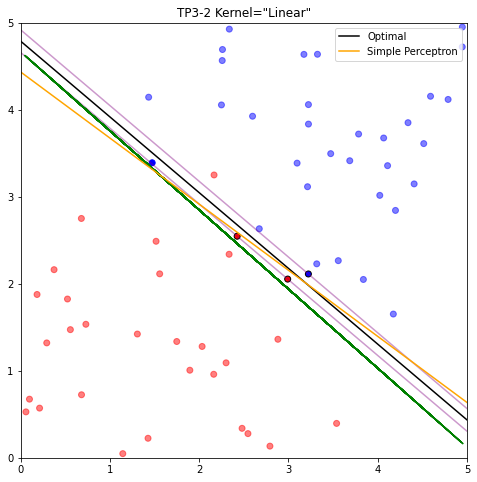

In [354]:
clfe = SVC(kernel='linear')
clfe.fit(X_ce, y_ce)
visualize(X_ce, y_ce, pe.min_weights, 'TP3-2 Kernel="Linear"', clf=clfe, optimum=True, n=2)
